# Series prediction 3

## Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

## Data

In [ ]:
import csv
time_step = []
sunspots = []
 
data=pd.read_csv('AirPassengers.csv', sep=',',encoding="utf8",names=['Date','pasajeros']) 
time=data.index[0:144]
df = pd.DataFrame(data)
series=np.array(df['pasajeros'][1:], dtype=float)
print(np.shape(series))
print(np.shape(time))

(144,)
(144,)


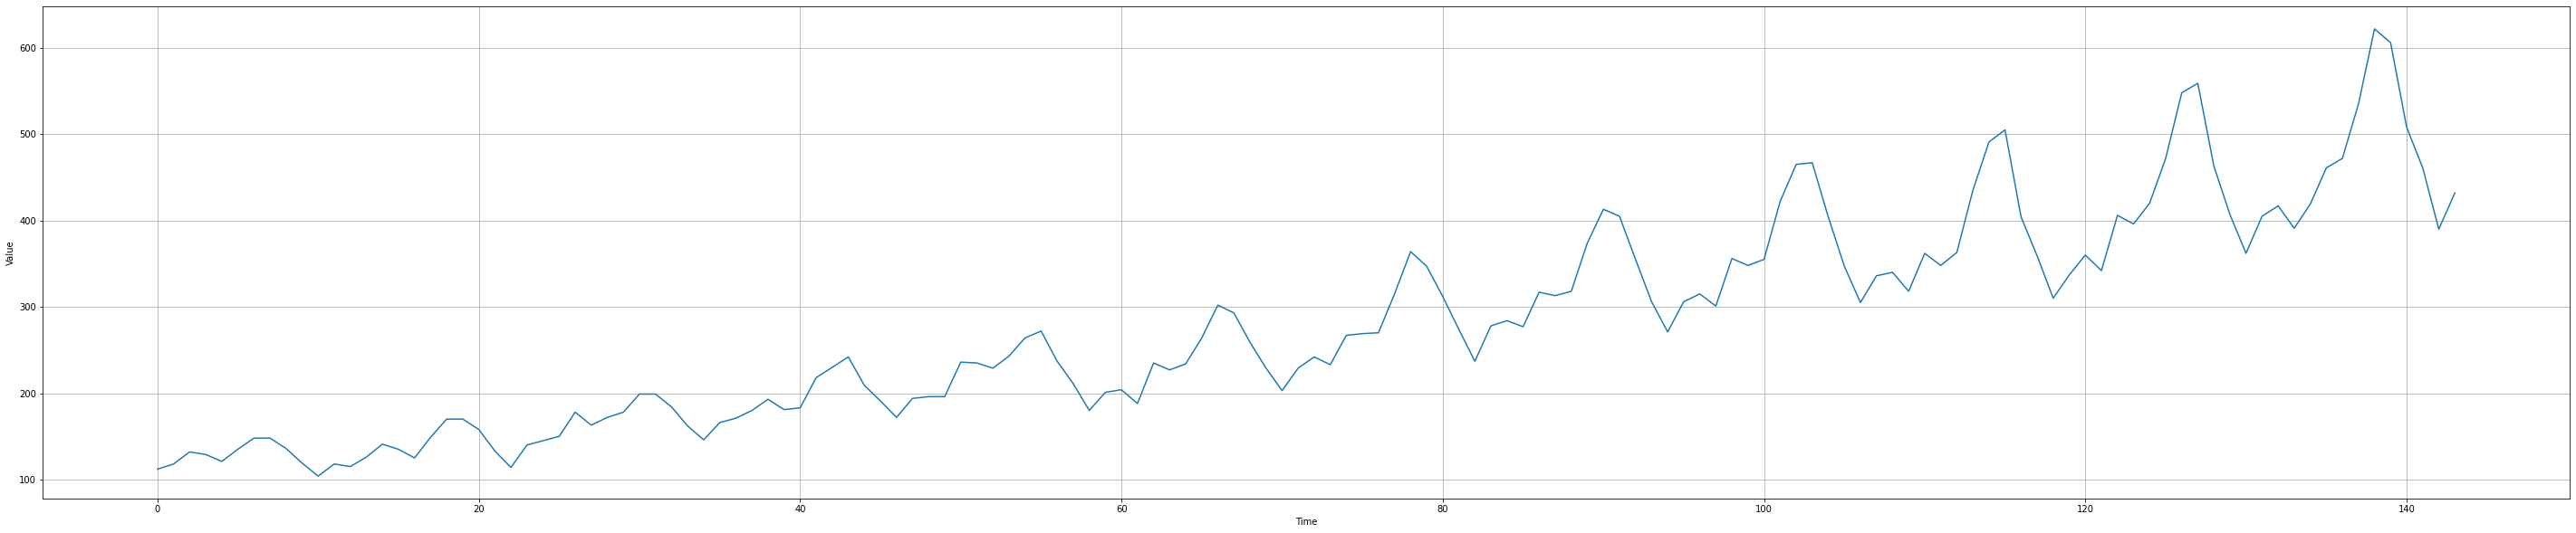

In [ ]:
plt.figure(figsize=(50,10))

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
plot_series(time, series)

## Train and validation sets

In [ ]:
split_time = 120
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
tf.keras.backend.clear_session()
train_set = windowed_dataset(x_train, window_size=10, batch_size=10, shuffle_buffer=120)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(120,)


## Model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(120, return_sequences=True),
  tf.keras.layers.LSTM(120, return_sequences=True),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 600)
])


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)


Epoch 1/500
11/11 [==============================] - 4s 16ms/step - loss: 197.5221 - mae: 198.0215
Epoch 2/500
11/11 [==============================] - 0s 14ms/step - loss: 111.7105 - mae: 112.2095
Epoch 3/500
11/11 [==============================] - 0s 14ms/step - loss: 94.5004 - mae: 95.0000
Epoch 4/500
11/11 [==============================] - 0s 18ms/step - loss: 76.3185 - mae: 76.8177
Epoch 5/500
11/11 [==============================] - 0s 15ms/step - loss: 75.3920 - mae: 75.8914
Epoch 6/500
11/11 [==============================] - 0s 15ms/step - loss: 60.3959 - mae: 60.8950
Epoch 7/500
11/11 [==============================] - 0s 16ms/step - loss: 50.8286 - mae: 51.3250
Epoch 8/500
11/11 [==============================] - 0s 17ms/step - loss: 50.0010 - mae: 50.4982
Epoch 9/500
11/11 [==============================] - 0s 16ms/step - loss: 44.4438 - mae: 44.9415
Epoch 10/500
11/11 [==============================] - 0s 16ms/step - loss: 44.3602 - mae: 44.8589
Epoch 11/500
11/11 [=====

## Prediction

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(10).prefetch(1)
    forecast = model.predict(ds)
    return forecast

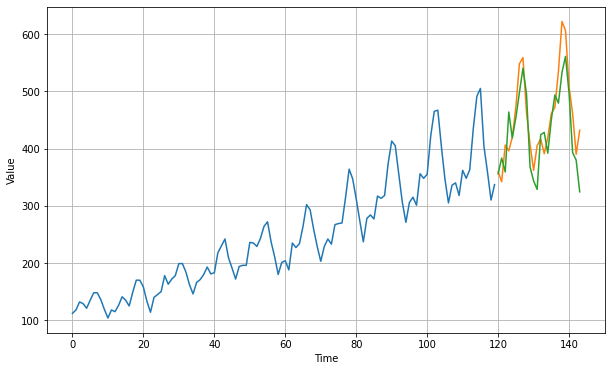

In [ ]:
window_size=10
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time[:split_time], series[:split_time])
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)